# А/В-тест для интернет-магазина

Работа по заданию маркетологов интернет-магазина.
Для обработки маркетологами был подготовлен список гипотез для увеличения выручки.
Необходимо было приоритизировать гипотезы, а также запустить A/B-тест и проанализировать результаты.

### Описание данных

Файл /datasets/hypothesis.csv. 
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv. 
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv.
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста


## Подготовка к исследованию

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
try:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
except:
    print('Ошибка загрузки')

In [4]:
# напишем функцию для проверки таблиц, выведем таблицы и получим информацию по ним
def head_info(df):
    display (df.head())
    display (df.info())
    print ('Число дубликатов:', df.duplicated().sum())
  

In [5]:
hypothesis.columns = hypothesis.columns.str.lower()
head_info(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

Число дубликатов: 0


In [6]:
orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}, inplace=True)
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
head_info(orders)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

Число дубликатов: 0


In [7]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
head_info(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

Число дубликатов: 0


В таблицах нет пропусков данных и дубликатов. Тип данных в столбце data в таблице orders и visitors был приведен к формату даты. В таблице orders переименованы столбцы transactionid и visitorid с целью приведения к единому стилю.

По данным по данным А/В-теста дополнительно проверим:
- Доли по кол-ву посетителей по группам 
- Пересечение пользователей

In [8]:
print('Число уникальных посетителей в разбивке по группам')
ord_gr = orders.pivot_table(index='group', values='visitor_id', aggfunc='nunique')
ord_gr.rename(columns={'visitor_id' : 'visitor_count'}, inplace=True)
ord_gr

Число уникальных посетителей в разбивке по группам


,visitor_count
group,
A,503
B,586


Распределение по группам корректное: 46% и 54% для групп А и В соответственно.

In [9]:
group_counter = orders.groupby('visitor_id')['group'].nunique()
bad_users = group_counter[group_counter > 1].index
print('Число пользователей, попавших в несколько групп:', len(bad_users))

Число пользователей, попавших в несколько групп: 58


5% от всех участников теста попало в несколько групп. В рамках данного проекта удалять таких пользователей мы не будем (по согласованию с заказчиком).

## Часть 1. Приоритизация гипотез

Применим фреймворки ICE и RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета. Посмотрим, есть ли различия.


$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [10]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)
     

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [11]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


In [12]:
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20


Разница в приоритизации гипотез связана с тем, что в фреймворке RICE учитывается в числителе параметр Reach (скольких пользователей затронет изменение, которое предполагается внести). Как мы видим в таблице hypothesis, у гипотезы 8 (Добавить форму подписки на все основные страницы..., индекс 7) Reach = 10, что значительно увеличивает значение RICE.
Этим объясняется различие в порядке приоритизации гипотез в нашем случае.

## Часть 2. Анализ A/B-теста

Проанализируем A/B-тест:
1.	Построим график кумулятивной выручки по группам. 
2.	Построим график кумулятивного среднего чека по группам. 
3.	Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 
4.	Построим график кумулятивной конверсии по группам. 
5.	Построим график относительного изменения кумулятивной конверсии группы B к группе A.
6.	Построим точечный график количества заказов по пользователям.
7.	Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.
8.	Построим точечный график стоимостей заказов. 
9.	Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.
10.	Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. 
11.	Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.
12.	Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 
13.	Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
14.	Примем решение по результатам теста и объясним его. 

In [13]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [14]:
# соберем грегированные кумулятивные по дням данные о заказах и о посетителях
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 

In [15]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head()) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


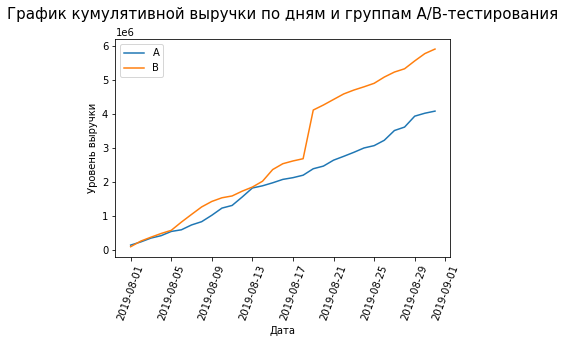

In [16]:
# построим графики кумулятивной выручки по дням и группам A/B-тестирования

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
degrees = 70
plt.xticks(rotation=degrees)
plt.xlabel('Дата')
plt.ylabel('Уровень выручки')
plt.title('График кумулятивной выручки по дням и группам A/B-тестирования', fontsize=15, pad = 20)
plt.legend() 
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Однако графики выручки обеих групп в нескольких точках резко растут. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

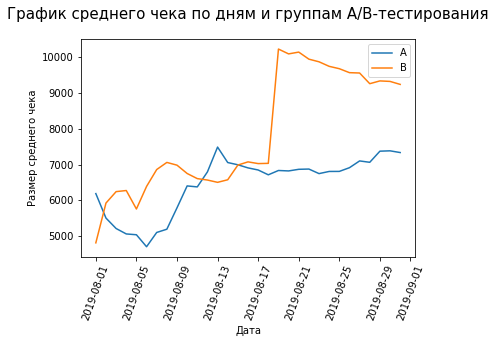

In [17]:
# построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
degrees = 70
plt.xticks(rotation=degrees)
plt.xlabel('Дата')
plt.ylabel('Размер среднего чека')
plt.title('График среднего чека по дням и группам A/B-тестирования', fontsize=15, pad = 20)
plt.legend() 
plt.show()

Средний чек тоже становится равномерным ближе к концу теста. Возможно, в группу B в середине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

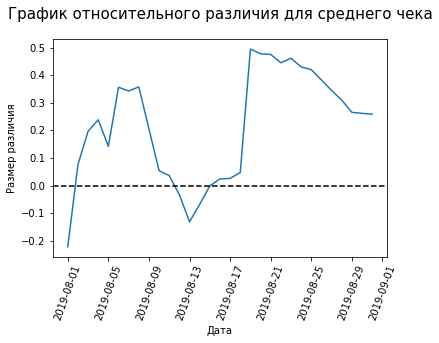

In [18]:
# построим график относительного различия для среднего чека

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
degrees = 70
plt.xticks(rotation=degrees)
plt.xlabel('Дата')
plt.ylabel('Размер различия')
plt.title('График относительного различия для среднего чека', fontsize=15, pad = 20)
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Возможно, это выбросы.

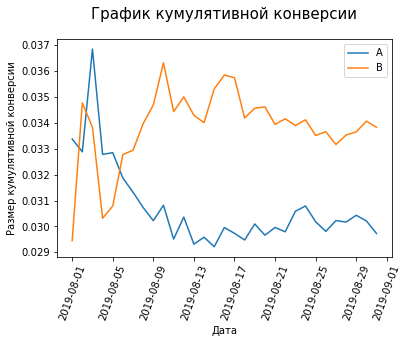

In [19]:
# построим график кумулятивной конверсии

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
degrees = 70
plt.xticks(rotation=degrees)
plt.xlabel('Дата')
plt.ylabel('Размер кумулятивной конверсии')
plt.title('График кумулятивной конверсии', fontsize=15, pad = 20)
plt.legend() 
plt.show()

Можно отметить колебания на всем исследуемом отрезке, нельзя однозначно сказать, что графики стабилизировались.

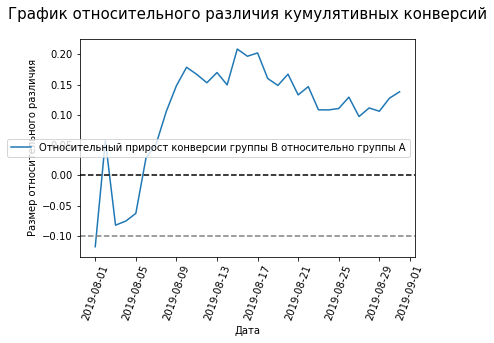

In [20]:
# построим график относительного различия кумулятивных конверсий

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
degrees = 70
plt.xticks(rotation=degrees)
plt.xlabel('Дата')
plt.ylabel('Размер относительного различия')
plt.title('График относительного различия кумулятивных конверсий', fontsize=15, pad = 20)
plt.legend() 
plt.show()

В начале теста группа B значительно проигрывала группе A, затем резко вырвалась вперёд. Потом её конверсия снова резко упала, но теперь наблюдается рост.
В целом отношение конверсии ещё не установилось.

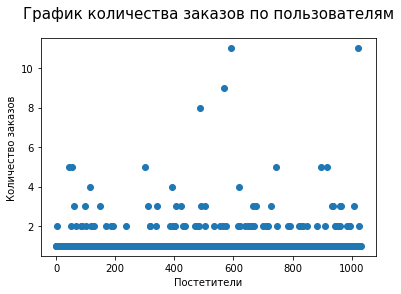

In [21]:
# построим график количества заказов по пользователям

ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.xlabel('Постетители')
plt.ylabel('Количество заказов')
plt.title('График количества заказов по пользователям', fontsize=15, pad = 20) 
plt.show()

Много пользователей с 1-2 заказами.

In [22]:
# посчитаем 95-й и 99-й перцентили количества заказов на пользователя

print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа. И 10% пользователей заказывали более 1 раза.
Выберем число заказов 2 на одного пользователя за нижнюю границу числа заказов.

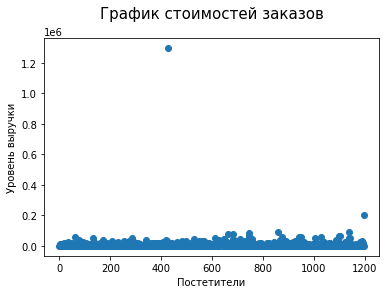

In [23]:
# построим точечный график стоимостей заказов

x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Постетители')
plt.ylabel('Уровень выручки')
plt.title('График стоимостей заказов', fontsize=15, pad = 20) 
plt.show()

Есть немного дорогих заказов.

In [24]:
# посчитаем 95-й и 99-й перцентили стоимости заказов

print(np.percentile(orders['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233 рублей. За нижнюю границу выберем 30 000.

### Анализ "сырых" и "очищенных" данных

В нашей работе будем использовать непараметрический тест Уилкоксона-Манна-Уитни. За критический уровень статистической значимости возьмем значение 0.05.

Нулевая гипотеза: статистически значимых различий в конверсии между группами нет. Альтернативная гипотеза: статистически значимые различия в конверсии между группами есть.

In [25]:
# посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

# Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.
# Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Округлим до трёх знаков после запятой.

print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительное изменение конверсии:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


p-value: 0.017
Относительное изменение конверсии: 0.138


Значение P-value меньше 0.05 - разница статистически значима. Различия в конверсии между группами по «сырым» данным есть. Относительный проигрыш группы А равен 13.8%.

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [26]:
# посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относиельное изменение конверсии:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.729
Относиельное изменение конверсии: 0.259


P-value значительно больше 0.05. Значит, причин считать, что в среднем чеке есть различия, нет. Средний чек группы B выше среднего чека группы A.

In [27]:
# сдеалем срезы анормальных пользователей: тех, кто совершил более 2 покупки и заказ был дороже 30 000.

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormalUsers.shape) 

(68,)


Всего 68 анормальных пользователей.

In [28]:
# посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

# применим статистический критерий Манна-Уитни к полученным выборкам

print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.013
0.172


Сильных изменений результатов по конверсии не наблюдается.

In [29]:
# посчитеаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

print('p-value:'
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное изменение конверсии:'
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 


p-value:0.720
Относительное изменение конверсии:-0.023


P-value уменьшился, но разница между сегментами очень сильно изменилась: относительный проигрыш группы B стал равен 2.3%.

## Выводы
<b>Приоритизация гипотез:</b> Разница в приоритизации гипотез с помощью фрейморков ICE и RICE связана с тем, что в фреймворке RICE учитывается в числителе параметр Reach (скольких пользователей затронет изменение, которое предполагается внести). Этим объясняется различие в порядке приоритизации гипотез в нашем случае.<br>
<b>Оценка А/В-теста:</b> Относительно результатов самого А/В-теста я бы предложила остановить тест, зафиксировать победу одной из групп. Хоть результаты каждой из групп еще колеблются, но результаты у группы В значительно и продолжительно по времени лучше результатов группы А.
